In [1]:
import Pkg
Pkg.activate("/home/alberto/GitHub/DynamicalShiftedFock")

  Activating project at `~/GitHub/DynamicalShiftedFock`


In [2]:
using QuantumToolbox
using CUDA
CUDA.allowscalar(false)
include("/home/alberto/GitHub/DynamicalShiftedFock/CairoMakie.jl")

In [3]:
import QuantumCumulants
using ModelingToolkit

In [4]:
data_folder = "/mnt/DATA/Datas/2024/Dynamical Shifted Fock/"

"/mnt/DATA/Datas/2024/Dynamical Shifted Fock/"

In [5]:
# CairoMakie.set_theme!(merge(deepcopy(theme_dark()), my_theme_Cairo))

In [6]:
# CairoMakie.set_theme!(my_theme_Cairo)

## Main figure

For the main figure, we choose the drive Jaynes-Cumming case case, and we plot the Wigner function at three different times.

In [7]:
# Parameters

F   = 5
Δ   = 0.0
γ   = 1
U = 0.002
g = 3

3

We first study a good region for the $\Delta$ parameter

In [8]:
N0 = 200

a0 = kron(destroy(N0), eye(2))
# a0 = cu(a0)

sm0 = kron(eye(N0), sigmam())
sp0 = kron(eye(N0), sigmap())
sz0 = kron(eye(N0), sigmaz());
# sm0 = cu(sm0)
# sp0 = cu(sp0)
# sz0 = cu(sz0);

In [9]:
Δ_list = range(-5, 5, 60)

ss_photons = similar(Δ_list)

pr = ProgressBar(length(Δ_list))
Threads.@threads for (i, Δ) in collect(enumerate(Δ_list))
    H0 = Δ*a0'*a0 + Δ/2 * sz0 + U*(a0^2)'*a0^2 + g*(a0*sp0 + a0'*sm0) + F*(a0+(a0)')
    c_ops0 = [√γ*a0, √γ*sm0]

    ρss = steadystate(H0, c_ops0, solver=SteadyStateLinearSolver(alg=KrylovJL_GMRES()))
    ss_photons[i] = real(expect(a0'*a0, ρss))

    next!(pr)
end

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 48s (ETA: 0h 00m 00s)


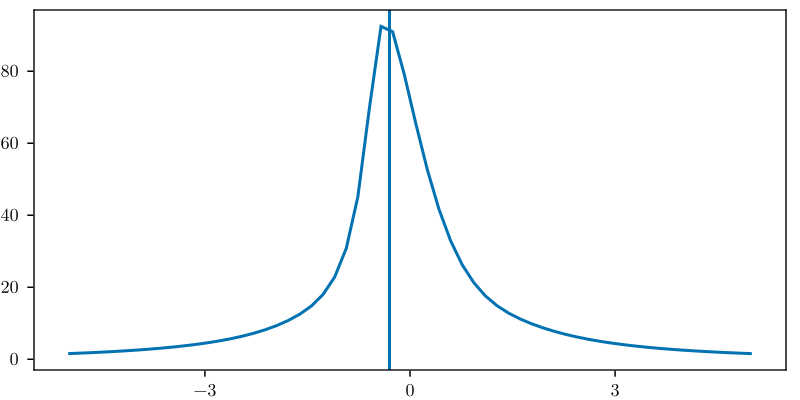

In [15]:
fig = Figure(size=(400, 200))
ax = Axis(fig[1, 1])

lines!(ax, Δ_list, ss_photons)

vlines!(ax, [-0.3])

fig

### Full Master Equation

In [26]:
Δ = -0.3

# a0 = cu(a0)
# sm0 = cu(sm0)
# sp0 = cu(sp0)
# sz0 = cu(sz0)

H0     = Δ*a0'*a0 + Δ/2 * sz0 + U*(a0^2)'*a0^2 + g*(a0*sp0 + a0'*sm0) + F*(a0+(a0)')
c_ops0 = [√γ*a0, √γ*sm0]

ψ0 = kron(fock(N0, 0), basis(2, 1))
# ψ0 = cu(ψ0)

tlist = range(0, 20/γ, 1000)
# tlist_save = range(tlist[1], tlist[end], 10)
tlist_save = [tlist[1], 2.2, tlist[end]]

sol = mesolve(H0, ψ0, tlist, c_ops0, e_ops=[a0'*a0, a0], saveat=tlist_save);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 36s (ETA: 0h 00m 00s)


### Dynamical Shifted Fock

In [18]:
function H_dsf(op_l, p)
    Δ = p.Δ
    U = p.U
    g = p.g
    F = p.F
    σm = p.σm
    σp = p.σp
    σz = p.σz

    a = op_l[1]

    return Δ*a'*a + Δ/2 * σz + U*(a^2)'*a^2 + g*(a*σp + a'*σm) + F*(a+(a)')
end

function c_ops_dsf(op_l, p)
    γ = p.γ
    σm = p.σm

    a = op_l[1]

    return [√γ*a, √γ*σm]
end

function e_ops_dsf(op_l, p)
    a = op_l[1]
    return [a'*a, a]
end

e_ops_dsf (generic function with 1 method)

In [27]:
N_dsf = 20

a = kron(destroy(N_dsf), eye(2))
σm = kron(eye(N_dsf), sigmam())
σp = kron(eye(N_dsf), sigmap())
σz = kron(eye(N_dsf), sigmaz())

op_l = [a]
α0_l = [expect(a0'*a0, ψ0)]

ψ0_dsf = kron(fock(N_dsf, 0), basis(2, 1))

p = (Δ=Δ, U=U, g=g, F=F, γ=γ, σm=σm, σp=σp, σz=σz)

sol_dsf = dsf_mesolve(H_dsf, ψ0_dsf, tlist, c_ops_dsf, op_l, α0_l, p, e_ops=e_ops_dsf, krylov_dim=5, δα_list=[0.2])

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1
num_expect = 2
ODE alg.: Tsit5(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
abstol = 1.0e-8
reltol = 1.0e-6


### Quantum Cumulants

In [28]:
# Define hilbert space
hc = QuantumCumulants.FockSpace(:cavity)
hq = QuantumCumulants.NLevelSpace(:atom,(:g,:e))
h = QuantumCumulants.tensor(hc,hq)

# Define the fundamental operators
a₁ = QuantumCumulants.Destroy(h,:a)
sm₁ = QuantumCumulants.Transition(h,:σ,:g,:e)
sz₁ = sm₁'*sm₁ - sm₁*sm₁'

QuantumCumulants.@cnumbers Δ₁ F₁ U₁ γ₁ G₁ g₁

# Hamiltonian
# H₁ = Δ₁*a₁'*a₁ + U₁*(a₁^2)'*a₁^2 + F₁*(a₁ + a₁') + G₁*((a₁^2)' + (a₁^2))
H₁ = Δ₁*a₁'*a₁ + Δ₁/2 * sz₁ + U₁*(a₁^2)'*a₁^2 + g₁*(a₁*sm₁ + a₁'*sm₁) + F₁*(a₁ + a₁')

# Collapse operators
Jumps₁ = [a₁]
rates₁ = [γ₁]

# Derive a set of equations
ops = [a₁, a₁' * a₁]
eqs = QuantumCumulants.meanfield(ops,H₁,Jumps₁;rates=rates₁,order=2)

# Expand the above equations to second order
eqs_expanded = QuantumCumulants.complete(eqs);

display(eqs_expanded)

# Generate an ODESystem
@named sys = ODESystem(eqs_expanded);

# Solve the system using the OrdinaryDiffEq package
u0 = zeros(ComplexF64, length(eqs_expanded))

p = (Δ₁, F₁, U₁, γ₁, g₁)
p0 = p .=> (Δ, F, U, γ, g)
prob = ODEProblem(sys, u0, (tlist[1],tlist[end]), p0, saveat=tlist, abstol=sol.abstol, reltol=sol.reltol)
sol_qc = solve(prob, Tsit5());

∂ₜ(⟨a⟩) = (0 - 1im)*F₁ + (0 - 1im)*g₁*⟨σge⟩ + (0 - 1im)*⟨a⟩*Δ₁ - 0.5⟨a⟩*γ₁ + (0 - 2im)*U₁*(2⟨a′*a⟩*⟨a⟩ + ⟨a′⟩*⟨a*a⟩ - 2⟨a′⟩*(⟨a⟩^2))
∂ₜ(⟨a′*a⟩) = (0 - 1im)*F₁*⟨a′⟩ + (0 + 1im)*F₁*⟨a⟩ + (0 + 1im)*g₁*⟨a*σge⟩ + (0 - 1im)*g₁*⟨a′*σge⟩ - ⟨a′*a⟩*γ₁
∂ₜ(⟨σge⟩) = (0//1 - 1//1*im)*⟨σge⟩*Δ₁
∂ₜ(⟨a*a⟩) = (0 - 2im)*F₁*⟨a⟩ + (0 - 2im)*U₁*⟨a*a⟩ + (0 - 2im)*g₁*⟨a*σge⟩ + (0 - 2im)*⟨a*a⟩*Δ₁ - ⟨a*a⟩*γ₁ + (0 - 4im)*U₁*(3⟨a′*a⟩*⟨a*a⟩ - 6⟨a′*a⟩*(⟨a⟩^2) - 6⟨a′⟩*⟨a⟩*⟨a*a⟩ + ⟨a′⟩*(3⟨a⟩*⟨a*a⟩ - 2(⟨a⟩^3)) + 6⟨a′⟩*(⟨a⟩^3) + 3(2⟨a′*a⟩*⟨a⟩ + ⟨a′⟩*⟨a*a⟩ - 2⟨a′⟩*(⟨a⟩^2))*⟨a⟩)
∂ₜ(⟨a*σge⟩) = (0 - 1im)*F₁*⟨σge⟩ + (0//1 - 2//1*im)*⟨a*σge⟩*Δ₁ - 0.5⟨a*σge⟩*γ₁ + (0 - 2im)*U₁*(2⟨a′*a⟩*⟨a*σge⟩ + ⟨a*a⟩*⟨a′*σge⟩ - 4⟨a′*a⟩*⟨a⟩*⟨σge⟩ - 4⟨a*σge⟩*⟨a′⟩*⟨a⟩ - 2⟨a′⟩*⟨a*a⟩*⟨σge⟩ - 2(⟨a⟩^2)*⟨a′*σge⟩ + 6⟨a′⟩*(⟨a⟩^2)*⟨σge⟩ + ⟨a′⟩*(2⟨a*σge⟩*⟨a⟩ + ⟨a*a⟩*⟨σge⟩ - 2(⟨a⟩^2)*⟨σge⟩) + (2⟨a′*a⟩*⟨a⟩ + ⟨a′⟩*⟨a*a⟩ - 2⟨a′⟩*(⟨a⟩^2))*⟨σge⟩ + 2(⟨a′*a⟩*⟨σge⟩ + ⟨a*σge⟩*⟨a′⟩ + ⟨a⟩*⟨a′*σge⟩ - 2⟨a′⟩*⟨a⟩*⟨σge⟩)*⟨a⟩)
∂ₜ(⟨a′*σge⟩) = (0 + 1im)*F₁*⟨σge⟩ - 0.5⟨a′*σge

We now find the last diagonal element of $\hat{\rho}_{t_1}$ that is larger than $10^{-4}$, that would be the selected Hilbert space dimension. The radius of the circle to draw will be the square root of that index.

In [29]:
population_tol = 1e-4

i = 2
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
ρt = ptrace(ρt, 1)
# max_population = abs.(real.(diag(ρt.data))) |> maximum
idx = findlast(>(population_tol), abs.(real.(diag(ρt.data))))
α2_max_full = sqrt(idx)

i = 3
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
ρt = ptrace(ρt, 1)
# max_population = abs.(real.(diag(ρt.data))) |> maximum
idx = findlast(>(population_tol), abs.(real.(diag(ρt.data))))
α3_max_full = sqrt(idx)

α_max_full = max(α2_max_full, α3_max_full)

11.445523142259598

In [30]:
xvec = range(-15, 15, 500)
yvec = range(-15, 15, 500)
xvec_gpu = CuArray(collect(xvec))
yvec_gpu = CuArray(collect(yvec))

i = 1
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
ρt = ptrace(ρt, 1)
α1, δα1 = get_coherence(ρt)
# max_population = abs.(real.(diag(δα1.data))) |> maximum
idx = findlast(>(population_tol), abs.(real.(diag(δα1.data))))
α1_max = sqrt(idx)
wig1 = wigner(ρt, xvec_gpu, yvec_gpu, g=2) |> Array
vmax1 = maximum(abs, wig1)

i = 2
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
ρt = ptrace(ρt, 1)
α2, δα2 = get_coherence(ρt)
# max_population = abs.(real.(diag(δα2.data))) |> maximum
idx = findlast(>(population_tol), abs.(real.(diag(δα2.data))))
α2_max = sqrt(idx)
wig2 = wigner(ρt, xvec_gpu, yvec_gpu, g=2) |> Array
vmax2 = maximum(abs, wig2)

i = 3
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
ρt = ptrace(ρt, 1)
α3, δα3 = get_coherence(ρt)
# max_population = abs.(real.(diag(δα3.data))) |> maximum
idx = findlast(>(population_tol), abs.(real.(diag(δα3.data))))
α3_max = sqrt(idx)
wig3 = wigner(ρt, xvec_gpu, yvec_gpu, g=2) |> Array
vmax3 = maximum(abs, wig3)

α_max = max(α1_max, α2_max, α3_max)

println(minimum(wig2), "  -  ", maximum(wig2))

-2.2366174388529358e-14  -  0.23809533071653396


In [23]:
function posFig(ax, x, y)
    o = ax.scene.viewport[].origin
    return Makie.project(ax.scene, Point2f(x, y)) + o
end

posFig (generic function with 1 method)

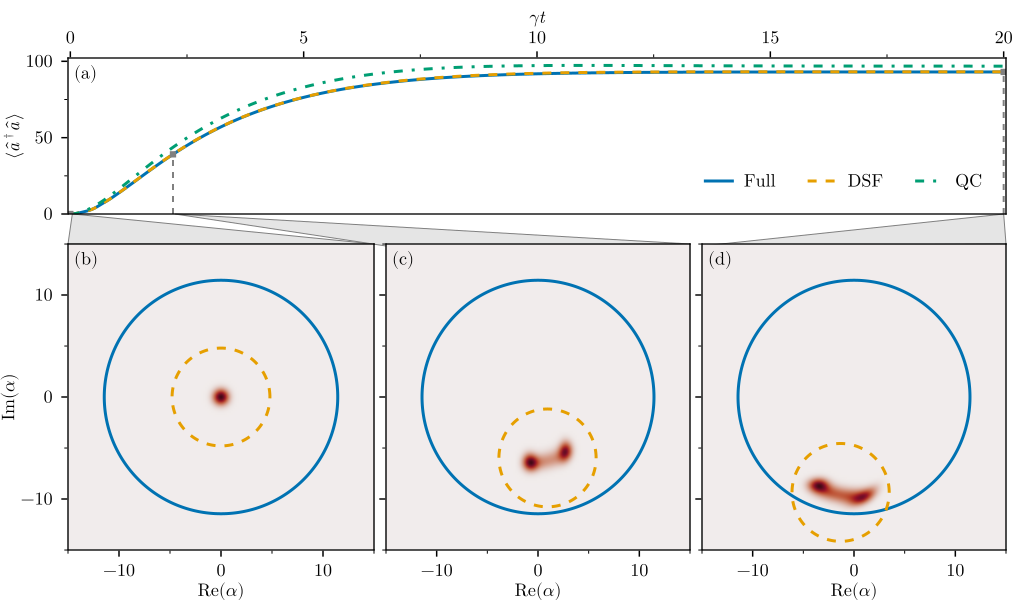

In [34]:
full_case_color = Makie.wong_colors()[1]
dsf_case_color = Makie.wong_colors()[2]
qc_case_color = Makie.wong_colors()[3]

fig = Figure(size=(plot_figsize_width_two_columns_pt, 300))

ax1 = Axis(fig[1, 1:3], xminorticksvisible=true, yminorticksvisible=true, xaxisposition=:top,
        xlabel = L"\gamma t", ylabel = L"\langle \hat{a}^\dagger \hat{a} \rangle")

ax2 = Axis(fig[2, 1], xticks=-10:10:10, yticks=-10:10:10, xminorticksvisible=true, yminorticksvisible=true, xlabel = L"\mathrm{Re}(\alpha)", ylabel = L"\mathrm{Im}(\alpha)")
ax3 = Axis(fig[2, 2], xticks=-10:10:10, yticks=-10:10:10, xminorticksvisible=true, yminorticksvisible=true, xlabel = L"\mathrm{Re}(\alpha)")
ax4 = Axis(fig[2, 3], xticks=-10:10:10, yticks=-10:10:10, xminorticksvisible=true, yminorticksvisible=true, xlabel = L"\mathrm{Re}(\alpha)")
# labelx = Label(fig[2, :], L"\mathrm{Re}(\alpha)")


lines!(ax1, tlist, real.(sol.expect[1, :]), label="Full", color=full_case_color)
lines!(ax1, tlist, real.(sol_dsf.expect[1, :]), label="DSF", linestyle=:dash, color=dsf_case_color)
lines!(ax1, sol_qc.t, real.(sol_qc[a₁'*a₁]), label="QC", linestyle=:dashdot, color=qc_case_color)
# lines!(ax1, tlist, abs2.(sol.expect[2, :]))
# vlines!(ax1, [2.6], color=:red)
scatter!(ax1, tlist_save, expect.(Ref(a0'*a0), sol.states), color=:grey, markersize=5, marker=:rect)
lines!(ax1, fill(tlist_save[1], 2), [0, expect(a0'*a0, sol.states[1])], color=:grey, linestyle=:dash, linewidth=1)
lines!(ax1, fill(tlist_save[2], 2), [0, expect(a0'*a0, sol.states[2])], color=:grey, linestyle=:dash, linewidth=1)
lines!(ax1, fill(tlist_save[3], 2), [0, expect(a0'*a0, sol.states[3])], color=:grey, linestyle=:dash, linewidth=1)

axislegend(ax1, orientation=:horizontal, position=:rb)


# heatmap!(ax2, xvec, yvec, Array(wigner(fock(N0, 70), xvec_gpu, yvec_gpu))', rasterize=true, colorrange=(-vmax1, vmax1), colormap=:balance, interpolate=true)
heatmap!(ax2, xvec, yvec, wig1', rasterize=true, colorrange=(-vmax1, vmax1), colormap=:balance, interpolate=true)
heatmap!(ax3, xvec, yvec, wig2', rasterize=true, colorrange=(-vmax2, vmax2), colormap=:balance, interpolate=true)
heatmap!(ax4, xvec, yvec, wig3', rasterize=true, colorrange=(-vmax3, vmax3), colormap=:balance, interpolate=true)

# contour!(ax2, xvec, yvec, wig1', levels=25, colorrange=(-vmax1, vmax1), colormap=:balance)
# contour!(ax3, xvec, yvec, wig2', levels=25, colorrange=(-vmax2, vmax2), colormap=:balance)
# contour!(ax4, xvec, yvec, wig3', levels=25, colorrange=(-vmax3, vmax3), colormap=:balance)

arc!(ax2, Point2(0, 0), α_max_full, 0, 2π, color=full_case_color)
arc!(ax3, Point2(0, 0), α_max_full, 0, 2π, color=full_case_color)
arc!(ax4, Point2(0, 0), α_max_full, 0, 2π, color=full_case_color)

arc!(ax2, Point2(real(α1), imag(α1)), α_max, 0, 2π, linestyle=:dash, color=dsf_case_color)
arc!(ax3, Point2(real(α2), imag(α2)), α_max, 0, 2π, linestyle=:dash, color=dsf_case_color)
arc!(ax4, Point2(real(α3), imag(α3)), α_max, 0, 2π, linestyle=:dash, color=dsf_case_color)

xlims!(ax1, tlist[1]-0.05, tlist[end]+0.05)
xlims!(ax2, xvec[1], xvec[end])
xlims!(ax3, xvec[1], xvec[end])
xlims!(ax4, xvec[1], xvec[end])

ylims!(ax1, 0, nothing)
ylims!(ax2, yvec[1], yvec[end])
ylims!(ax3, yvec[1], yvec[end])
ylims!(ax4, yvec[1], yvec[end])

linkyaxes!(ax2, ax3, ax4)
ax3.yticklabelsvisible = false
ax4.yticklabelsvisible = false





rowsize!(fig.layout, 2, Aspect(2, 1))
# colsize!(fig.layout, 2, Aspect(1, 1))
colgap!(fig.layout, 3)
rowgap!(fig.layout, 15)




text!(ax1, 0, 1, text = "(a)", align = (:left, :top), offset = (3, -3), space = :relative)
text!(ax2, 0, 1, text = "(b)", align = (:left, :top), offset = (3, -3), space = :relative)
text!(ax3, 0, 1, text = "(c)", align = (:left, :top), offset = (3, -3), space = :relative)
text!(ax4, 0, 1, text = "(d)", align = (:left, :top), offset = (3, -3), space = :relative)



poly_y_offset = -1 # For some reason we need an offset of -1.
poly_kwargs = (color=:grey90, strokecolor=:grey, strokewidth=0.5, linestyle=:solid, alpha=0.5)

ax_origin = ax2.scene.viewport[].origin
ax_widths = ax2.scene.viewport[].widths
snapshot_point = posFig(ax1, tlist_save[1], 0)
poly_x = [snapshot_point[1], ax_origin[1], ax_origin[1] + ax_widths[1]]
poly_y = [snapshot_point[2] + poly_y_offset, ax_origin[2] + ax_widths[1], ax_origin[2] + ax_widths[2]]
poly!(fig.scene, collect(zip(poly_x, poly_y)); poly_kwargs...)

ax_origin = ax3.scene.viewport[].origin
ax_widths = ax3.scene.viewport[].widths
snapshot_point = posFig(ax1, tlist_save[2], 0)
poly_x = [snapshot_point[1], ax_origin[1], ax_origin[1] + ax_widths[1]]
poly_y = [snapshot_point[2] + poly_y_offset, ax_origin[2] + ax_widths[1], ax_origin[2] + ax_widths[2]]
poly!(fig.scene, collect(zip(poly_x, poly_y)); poly_kwargs...)

ax_origin = ax4.scene.viewport[].origin
ax_widths = ax4.scene.viewport[].widths
snapshot_point = posFig(ax1, tlist_save[3], 0)
poly_x = [snapshot_point[1], ax_origin[1], ax_origin[1] + ax_widths[1]]
poly_y = [snapshot_point[2] + poly_y_offset, ax_origin[2] + ax_widths[1], ax_origin[2] + ax_widths[2]]
poly!(fig.scene, collect(zip(poly_x, poly_y)); poly_kwargs...)

# translate!(prova_scatter, 0, 0, 1)

save(joinpath(data_folder, "DSF_master_equation.pdf"), fig, pt_per_unit=1)

fig

In [35]:
prova = rand(2, 4)

2×4 Matrix{Float64}:
 0.354383  0.862198  0.387937  0.19457
 0.452847  0.153228  0.595634  0.380695

In [36]:
cazzo = rand(2)

2-element Vector{Float64}:
 0.3025360282777274
 0.5549750390496723

In [41]:
prova1 = sprand(10, 10, 0.1)
prova2 = sprand(10, 10, 0.1)

10×10 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
  ⋅    ⋅    ⋅    ⋅        0.468194   ⋅    ⋅        ⋅    ⋅   0.0411853
  ⋅    ⋅    ⋅   0.333219   ⋅         ⋅   0.84673   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅         ⋅         ⋅    ⋅        ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅         ⋅         ⋅    ⋅        ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅         ⋅         ⋅    ⋅        ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅         ⋅         ⋅    ⋅        ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅         ⋅         ⋅    ⋅        ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅         ⋅         ⋅    ⋅        ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅         ⋅         ⋅    ⋅        ⋅    ⋅   0.679172
  ⋅    ⋅    ⋅    ⋅        0.623595   ⋅    ⋅        ⋅    ⋅    ⋅ 

In [42]:
vcat(prova1, prova2)

20×10 SparseMatrixCSC{Float64, Int64} with 18 stored entries:
⎡⠀⠀⠁⠈⡀⎤
⎢⢒⢐⠀⠀⠈⎥
⎢⠀⢀⠆⡁⠰⎥
⎢⠀⠀⠀⠀⠀⎥
⎣⠀⠀⡀⠀⠠⎦

In [44]:
prova1 = rand(2, 4)

2×4 Matrix{Float64}:
 0.350686  0.218819  0.959795  0.450556
 0.107346  0.781952  0.613358  0.405916

In [45]:
prova1_reshape = reshape(prova1, :)

8-element Vector{Float64}:
 0.35068589808255246
 0.10734609507658954
 0.21881872907525812
 0.7819524018102955
 0.9597946640925243
 0.6133579274886085
 0.450555758855797
 0.4059160690048974